# FireCode Compliant

## Authors:
    1)Vincent Bensawan A14778583
    2)Kyle Gillaspy A15010717
    3)Oscar Jimenez A15089826
    4)Sayaka Kuwayama A13443139
    5)Ritaj Mangush A14251679
    6)Nancy Nguyen A13708655
## Introduction and Background
1) **REASEARCH QUESTION:**

Is it possible to analyse wildfires in order to efficiently allocate firefighting resources to mitigate future ocurrances?

2) **HYPOTHESIS:**

We believe it’s possible to analyse the different risk levels of areas in danger of being affected by wildfires which would allow us to pinpoint the best places and time periods to allocate firefighting resources. 
    **We define "efficient allocation" to be:**
    

    Hypothesis:
    
    Null Hypothesis:

3) **BACKGROUND:**

Wildfires can burn acres of land within minutes, they become uncontrolled when fueled by weather, wind, and dry underbrush. Such wildfires cause devastating ecological and economic impacts.There has been significant discussion of what role forest management can and can’t play in preventing wildfires. Naturally occurring wildfires play an integral role in nature but are very destructive to humans. They return nutrients to the soil by burning dead or decaying matter.  It becomes important to employ mechanisms to better predict wildfires and fire behaviour once it started. 

In 2018, California experienced one of the deadliest wildfires on record that devastated hundred thousand acres of land and affected the air quality of the Northern California regions. Several articles pointed out that the wildfire is caused by numerous factors such bad climate conditions and human activities. It was also discussed that one of the challenges in putting out the wildfire is the lack of personnel.

We wanted to find out whether it’s possible to assess areas with risk levels according to how the area is vulnerable from catching fire. We are aiming to try and incorporate this data with wind data, time since there has been a fire in this area, human visitation statistics, and lightning fire data, to help assess possibly overlooked areas. By determining the risk levels of different areas, we hope to be able to map the best way to allocate firefighting resources to improve firefighting efficiency. Similar projects have looked at fire data in relation to its economic effects, as a UC Davis Project team used fire boundary data to provide wineries in California with the most up-to-date risk assessments for wildfires (https://github.com/UCDavisLibrary/ava).
The goal is to have communities with emergency plans and preparations ready in these “high risk” areas.


4) **ETHICAL & PRIVACY CONSIDERATIONS: **

The datasets to be used for our project are easily accessible by the public and can be found on Federal.gov websites, this means there is not a concern regarding privacy issues. Moreover, we believe the outcome of our research would not produce an ethical issue since it is concerned with improving public readiness to combat and avoid wildfires. Since our data is also based on objective statistics, there is no bias regarding the data we will be using since the data is compiled using satellite imaging.


## Graph of Fire Frequencies by County

In [8]:
from IPython.display import IFrame
IFrame(".\map.html", width='100%', height='800')

### More Context :

Here we can see that our map seems to have no apprent patterns at first glance, we hope to be able to make sense of this map to better predict wildfires to allocate firefighting resources more effectively!

Our analysis continues after we show our Data Gathering and Data Wrangling proccesses . . .

# DATASETS

We will derive our datasets from publicly available resources specifically on the federal level. We would like to use both tabular and GIS data in order to drive more complex analysis and data visualization. We chose these particular datasets because they are both public and backed by the federal government. Although government datasets are often messy, their data collection methods are effective and trusted especially for the hands-on nature of the hypothesis. 

1) **GEOJSON**
    This GeoJSON file contains the boundries for all California Counties as drawn by CALFIRE's Fire and Resource Assessment Program (FRAP). This dataset will help in determining boundries for map vizualizations.

Data Source: https://data.ca.gov/dataset/california-counties

2) **SQL Database**
    SQL Lite database obtained from Kaggle contains 1.88 million wildfires throughout the US and US Territories. For the purposes of our analysis we will only use fires that are located in California. This dataset contains a myriad of information such as different ID types, latitude and longitude measurements, fire size, discovery date, and containment date. This dataset will be used in conjunction with the GeoJSON file to make the map vizualizations

Data Source: https://www.kaggle.com/rtatman/188-million-us-wildfires

3) **PDF SCRAPING**
    Unfortunately there is not any good datasets for wildfires that are in a nice format. For this reason, we have decided to collect the data ourselves the messy way from... PDF files. The PDF format was not meant to be read by a computer but by using the Tabula package, an open source PDF scraper, we are able to read pdf tables directly to pandas DataFrames. The tool was far from perfect, combined with inconsistencies in government data collection, required each pdf to be scraped individually page by page. To further complicate things, the DataFrames read are very messy. Data cleaning/data wrangling will be covered in the next section.

Link to example pdf: http://cdfdata.fire.ca.gov/pub/cdf/images/incidentstatsevents_272.pdf

Data Source: http://cdfdata.fire.ca.gov/incidents/incidents_statsevents


## Special Steps:
Our dataset is created by merging cleaned data from a variety of places, utilizing SQL, Tabula, and GEOJSON datasets. This extends our data wrangling and cleaning processes, however it is well worth the effort!

## IMPORTS



In [2]:
#there will be more packages added as needed in following cells
#standard datascience packages
import pandas as pd
import numpy as np

#packages for reading geojson file
import json
import os

#package for reading sql lite database
import sqlite3

#package for map making
import folium

#package for accurate date/time manipulations
import datetime

#note this package is NOT native to Anaconda, follow tabula
#documentation for steps on installation
#package for PDF scraping
import tabula



## DATA GATHERING

### 1) GEOJSON

This GeoJSON file contains the boundries for all California Counties as drawn by CALFIRE's Fire and Resource Assessment Program (FRAP). This dataset will help in determining boundries for map vizualizations.

**Data Source:** https://data.ca.gov/dataset/california-counties

In [3]:
ca_counties = json.load(open('California_Counties.geojson'))

### 2) SQL Database

SQL Lite database obtained from Kaggle contains 1.88 million wildfires throughout the US and US Territories. For the purposes of our analysis we will only use fires that are located in California. This dataset contains a myriad of information such as different ID types, latitude and longitude measurements, fire size, discovery date, and containment date. This dataset will be used in conjunction with the GeoJSON file to make the map vizualizations

**Data Source:** https://www.kaggle.com/rtatman/188-million-us-wildfires

In [4]:
conn = sqlite3.connect("fires_sql.sqlite")
fires = pd.read_sql_query("SELECT * FROM fires", conn)

### PDF SCRAPING

Unfortunately there is not any good datasets for wildfires that are in a nice format. For this reason, we have decided to collect the data ourselves the messy way from... PDF files. The PDF format was not meant to be read by a computer but by using the `Tabula` package, an open source PDF scraper, we are able to read pdf tables directly to pandas DataFrames. The tool was far from perfect, combined with inconsistencies in government data collection, required each pdf to be scraped individually page by page. To further complicate things, the DataFrames read are very messy. Data cleaning/data wrangling will be covered in the next section.

**Link to example pdf:** http://cdfdata.fire.ca.gov/pub/cdf/images/incidentstatsevents_272.pdf

**Data Source:** http://cdfdata.fire.ca.gov/incidents/incidents_statsevents

**WARNING: This may take a few minutes**

In [5]:
#we will scrape some data directly from pdf using tabula open source pdf reader.

#variable format largest_[year]_[page]
#2012 link is broken
# (do this later) TODO: drop anything that is missing a date
raw_fire_array = []
#2000 2 pages
largest_2000_1 = tabula.read_pdf('largest_2000.pdf', pages=1, area=[60, 105, 1004, 800])
raw_fire_array.append(largest_2000_1)
largest_2000_2 = tabula.read_pdf('largest_2000.pdf', pages=2, area=[60, 51, 1004, 650])
raw_fire_array.append(largest_2000_2)
#2001 2 pages
largest_2001_1 = tabula.read_pdf('largest_2001.pdf', pages=1, area=[100, 88, 952, 792])
raw_fire_array.append(largest_2001_1)
largest_2001_2 = tabula.read_pdf('largest_2001.pdf', pages=2, area=[100, 46, 952, 623])
raw_fire_array.append(largest_2001_2)
#2002 3 pages
largest_2002_1 = tabula.read_pdf('largest_2002.pdf', pages=1, area=[76, 104, 1010, 797])
raw_fire_array.append(largest_2002_1)
largest_2002_2 = tabula.read_pdf('largest_2002.pdf', pages=2, area=[76, 50, 1010, 786])
raw_fire_array.append(largest_2002_2)
largest_2002_3 = tabula.read_pdf('largest_2002.pdf', pages=3, area=[76, 50, 1010, 681])
raw_fire_array.append(largest_2002_3)
#2003 3 pages
largest_2003_1 = tabula.read_pdf('largest_2003.pdf', pages=1, area=[58, 81, 1015, 787])
raw_fire_array.append(largest_2003_1)
largest_2003_2 = tabula.read_pdf('largest_2003.pdf', pages=2, area=[58, 33, 1015, 784])
raw_fire_array.append(largest_2003_2)
largest_2003_3 = tabula.read_pdf('largest_2003.pdf', pages=3, area=[58, 33, 1015, 169])
raw_fire_array.append(largest_2003_3)
#end(largest_2016_3)
#45 total pages!

In [6]:
#2004 2 pages
largest_2004_1 = tabula.read_pdf('largest_2004.pdf', pages=1, area=[81, 125, 1017, 797])
raw_fire_array.append(largest_2004_1)
largest_2004_2 = tabula.read_pdf('largest_2004.pdf', pages=2, area=[81, 76, 1017, 646])
raw_fire_array.append(largest_2004_2)
#2005 3 pages
largest_2005_1 = tabula.read_pdf('largest_2005.pdf', pages=1, area=[110, 86, 958, 793])
raw_fire_array.append(largest_2005_1)
largest_2005_2 = tabula.read_pdf('largest_2005.pdf', pages=2, area=[110, 86, 958, 793])
raw_fire_array.append(largest_2005_2)
largest_2005_3 = tabula.read_pdf('largest_2005.pdf', pages=3, area=[110, 86, 958, 385])
raw_fire_array.append(largest_2005_3)
#2006 4 pages
largest_2006_1 = tabula.read_pdf('largest_2006.pdf', pages=1, area=[64, 90, 1005, 806])
raw_fire_array.append(largest_2006_1)
largest_2006_2 = tabula.read_pdf('largest_2006.pdf', pages=2, area=[64, 90, 1005, 806])
raw_fire_array.append(largest_2006_2)
largest_2006_3 = tabula.read_pdf('largest_2006.pdf', pages=3, area=[64, 90, 1005, 806])
raw_fire_array.append(largest_2006_3)
largest_2006_4 = tabula.read_pdf('largest_2006.pdf', pages=4, area=[64, 90, 1005, 633])
raw_fire_array.append(largest_2006_4)

In [7]:
#2007 3 pages
largest_2007_1 = tabula.read_pdf('largest_2007.pdf', pages=1, area=[97, 86, 973, 793])
raw_fire_array.append(largest_2007_1)
largest_2007_2 = tabula.read_pdf('largest_2007.pdf', pages=2, area=[97, 86, 973, 793])
raw_fire_array.append(largest_2007_2)
largest_2007_3 = tabula.read_pdf('largest_2007.pdf', pages=3, area=[97, 86, 973, 634])
raw_fire_array.append(largest_2007_3)
#2008 6 pages
largest_2008_1 = tabula.read_pdf('largest_2008.pdf', pages=1, area=[69, 86, 1034, 804])
raw_fire_array.append(largest_2008_1)
largest_2008_2 = tabula.read_pdf('largest_2008.pdf', pages=2, area=[69, 86, 1034, 804])
raw_fire_array.append(largest_2008_2)
largest_2008_3 = tabula.read_pdf('largest_2008.pdf', pages=3, area=[69, 86, 1034, 804])
raw_fire_array.append(largest_2008_3)
largest_2008_4 = tabula.read_pdf('largest_2008.pdf', pages=4, area=[69, 86, 1034, 804])
raw_fire_array.append(largest_2008_4)
largest_2008_5 = tabula.read_pdf('largest_2008.pdf', pages=5, area=[69, 86, 1034, 804])
raw_fire_array.append(largest_2008_5)
largest_2008_6 = tabula.read_pdf('largest_2008.pdf', pages=1, area=[69, 86, 1034, 260])
raw_fire_array.append(largest_2008_6)
#2009 3 pages
largest_2009_1 = tabula.read_pdf('largest_2009.pdf', pages=1, area=[72, 199, 1052, 780])
raw_fire_array.append(largest_2009_1)
largest_2009_2 = tabula.read_pdf('largest_2009.pdf', pages=2, area=[72, 89, 1052, 788])
raw_fire_array.append(largest_2009_2)
largest_2009_3 = tabula.read_pdf('largest_2009.pdf', pages=3, area=[72, 89, 1052, 390])
raw_fire_array.append(largest_2009_3)

In [8]:
#2010 2 pages
largest_2010_1 = tabula.read_pdf('largest_2010.pdf', pages=1, area=[69, 435, 1052, 780])
raw_fire_array.append(largest_2010_1)
largest_2010_2 = tabula.read_pdf('largest_2010.pdf', pages=2, area=[69, 88, 1052, 738])
raw_fire_array.append(largest_2010_2)
#2011 2 pages
largest_2011_1 = tabula.read_pdf('largest_2011.pdf', pages=1, area=[86, 117, 1037, 815])
raw_fire_array.append(largest_2011_1)
largest_2011_2 = tabula.read_pdf('largest_2011.pdf', pages=2, area=[86, 121, 1037, 731])
raw_fire_array.append(largest_2011_2)
#2013 2 pages (remember 2012 link is broken)
largest_2013_1 = tabula.read_pdf('largest_2013.pdf', pages=1, area=[102, 90, 960, 785])
raw_fire_array.append(largest_2013_1)
largest_2013_2 = tabula.read_pdf('largest_2013.pdf', pages=2, area=[102, 50, 960, 417])
raw_fire_array.append(largest_2013_2)

In [9]:
#2014 2 pages
largest_2014_1 = tabula.read_pdf('largest_2014.pdf', pages=1, area=[220, 155, 1658, 1332])
raw_fire_array.append(largest_2014_1)
largest_2014_2 = tabula.read_pdf('largest_2014.pdf', pages=2, area=[220, 155, 1658, 818])
raw_fire_array.append(largest_2014_2)
#2015 3 pages
largest_2015_1 = tabula.read_pdf('largest_2015.pdf', pages=1, area=[43, 93, 1058, 717])
raw_fire_array.append(largest_2015_1)
largest_2015_2 = tabula.read_pdf('largest_2015.pdf', pages=2, area=[43, 125, 1058, 670])
raw_fire_array.append(largest_2015_2)
largest_2015_3 = tabula.read_pdf('largest_2015.pdf', pages=3, area=[43, 107, 1058, 346])
raw_fire_array.append(largest_2015_3)
#2016 3 pages
largest_2016_1 = tabula.read_pdf('largest_2016.pdf', pages=1, area=[38, 162, 1061, 792])
raw_fire_array.append(largest_2016_1)
largest_2016_2 = tabula.read_pdf('largest_2016.pdf', pages=2, area=[38, 177, 1061, 786])
raw_fire_array.append(largest_2016_2)
largest_2016_3 = tabula.read_pdf('largest_2016.pdf', pages=3, area=[38, 100, 1061, 372])
raw_fire_array.append(largest_2016_3)

### Messy DataFrame Example

The table is practically unreadable, many problems to fix such as combined columns, NaN/missing columns, useless rows, and incorrect/missing column names.

In [10]:
# This is an example of our dataframe before cleaning
largest_2004_1.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,DATE,Unnamed: 4,ACRES BURNED,VEG.,Unnamed: 7,STRUCTURESFATALITIES
0,INC. # COUNTY,NaN,FIRE NAME,START CONT. DPA,NaN,CDF OTHER TOTAL,TYPE,CAUSE,DEST. DAM. FIRE CIVIL
1,BDF-3917 SAN BERNARDINO,NaN,UPPER SANTA ANA,03/25/04 03/26/04 USFS,NaN,350 350,BT,ESCAPE,1 0 0 0
2,SHF-000443 TEHAMA,NaN,SHF ASSIST (HAMILTON),04/09/04 04/12/04 USFS,NaN,301 301,T,HUMAN,0 0 0 0
3,RRU-032913 RIVERSIDE,NaN,PLEASURE FIRE,04/25/04 04/26/04 CDF,NaN,"2,464 2,464",GB,VEHICLE,9 0 0 0
4,MVU-003337 SAN DIEGO,NaN,ASSIST #31 (INDIA FIRE),05/02/04 05/03/04 MIL.,NaN,"2,040 2,040",BT,UI,0 0 0 0


# Data Cleaning/Wrangling

### UNIVERSAL VARIABLES

In [11]:
#Row names for cleaned tables
ROWS_N = ['INCIDENT #', 'COUNTY/UNIT', 'FIRE_NAME', 'START_DATE', 
          'CONT_DATE', 'ORIGIN_DPT', 'BURNED_TOTAL', 'VEG_TYPE', 
          'CAUSE', 'STRUCT_DEST', 'STRUCT_DAM', 'FATALITY_FIRE', 
          'FATALITY_CIVIL']
STRUCT_ROW = ['STRUCT_DEST', 'STRUCT_DAM']
FATAL_ROW = ['FATALITY_FIRE', 'FATALITY_CIVIL']

### HELPER FUNCTIONS

In [12]:
#TODO: Fix 2000 - 2002 Years to use robust_col_sep
"""
NOTE: this only works for fatality and structural columns

column_separator(df, col, new_names)

Separates one column into two (if values are separated by spaces)

params:
df : DataFrame to change
col : column name to split
new_names : array of 2 new names for columns

returns:
pandas DataFrame with changes applied
"""
def column_separator(df, col, new_names):
    column = df[col].astype(str).apply(lambda x : x.split(' '))
    left_arr = []
    right_arr = []
    #uncomment below to see actual array values
    #display(column)
    
    #iterate through values to separate them
    for val in column:
        #edge case array is len 1
        if len(val) == 1:
            left_arr.append(np.nan)
            right_arr.append(np.nan)
        #normal case array len 2
        elif len(val) == 2:
            left_arr.append(val[0])
            right_arr.append(val[1])
        #edge case array is bigger than expected
        else:
            left_arr.append('error')
            right_arr.append('error')
    #now make new column names and remove the old one
    #display(left_arr)
    #display(right_arr)
    ans_df = df.drop(col, axis=1)
    ans_df[new_names[0]] = left_arr
    ans_df[new_names[1]] = right_arr
    return ans_df
"""
robust_col_sep(df, iloc, new_names, front=True)

Separates one column into two columns, values must be separated by spaces; drops the original column at iloc index

params:

df : the dataframe to modify
index : the index of the column as given by iloc indexing (int)
new_names : the new names for the two new columns created (array size 2)
front : determines whether to separate the value from the front or from the back (boolean, optional):

Example:
Consider the following string:
Apple Cinnamon Bannana

front = True will give
[Apple] [Cinnamon Bannana]

front = False will give
[Apple Cinnamon] [Bannana]

returns:
pandas DataFrame with changes applied
"""

def robust_col_sep(df, index, new_names, front=True):
    column = df.iloc[:, index].astype(str).apply(lambda x : x.split(' '))
    left_arr = []
    right_arr = []
    
    #display(column)
    #iterate through column vals
    for val in column:
        if front:
            left_arr.append(val[0])
            right_arr.append(' '.join(val[1:]))
        #if not front
        else:
            left_arr.append(' '.join(val[:-1]))
            right_arr.append(val[-1])
    #make new cols and drop old
    ans_df = df.drop(df.columns[index], axis=1)
    #add right column first
    #display(len(left_arr))
    #display(len(right_arr))
    #display(len(df.index))
    ans_df.insert(index, new_names[1], right_arr)
    ans_df.insert(index, new_names[0], left_arr)
    return ans_df


#TODO: Write documentation for this
def transposer(df, r, c, item, d):
    frame = df.copy()
    frame.iloc[r,c] = frame.iloc[r,c].replace(item, '')
    if frame.iloc[r,c] == df.iloc[r,c]:
        frame.iloc[r,c] = df.iloc[r,c]
        return frame
    else:
        if 'left' in d:
            frame.iloc[r,c-1] = item
        elif 'right' in d:
            frame.iloc[r,c+1] = item
        else:
            raise Exception('please use left or right')
        return frame

############################################################################
#                           APPLY HELPER FUNCTIONS                         #
############################################################################

'''
APPLY HELPER FUNCTION (used in Series.apply() only)

Takes in an array with year and DOY (Day Of Year) and converts it to a datetime object.
This function is needed due to odd dating format in SQL table
'''
def datetime_convert_sql(year_day_array):
    year = int(year_day_array[0])
    #issue with nan values not converting to int values
    try:
        day = int(year_day_array[1].split('.')[0])
        ans = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day-1)
    except ValueError:
        ans = np.nan
    return ans
'''
APPLY HELPER FUNCTION (used in Series.apply() only)

Takes in a string in the format MM/DD/YY and converts it to a datetime object
This function is needed due to YY format and NaN error handling
'''
def datetime_convert_pdf(date):
    date_arr = date.split('/')
    if len(date_arr) == 3:
        try:
            return datetime.datetime(int('20'+date_arr[2].split('.')[0]), int(date_arr[0]), int(date_arr[1]))
        except ValueError:
            return np.nan
    else:
        return np.nan
'''
APPLY HELPER FUNCTION (used in Series.apply() only)

Takes in a string value and converts to integer value
This function is needed for NaN value handleing to join PDF table and SQL table
'''
def int_convert(val):
    try:
        ans = int(val.replace(",", ""))
    except:
        ans = 0
    return ans

# TODO: add documentation for this function
def county_cleaner(c, c_lst):
    #remove any dashes
    string = c.split("-")[0]
    #remove any slashes
    string = c.split("/")[0]
    #standardize
    string = string.title().strip(" ")
    #use n_grams to match to potential couny
    string_split = string.split(" ")
    for i in np.arange(len(string_split)+1):
        n_gram = " ".join(string_split[0:i]) + " County"
        if n_gram in c_lst:
            return n_gram
    return np.nan

### SQL TABLE CLEANING

The SQL table is largely clean already, we will just drop a few extra columns and convert the strange dates into datetime objects as well as clean up the `FIRE_SIZE` column into `int` format.

In [13]:
#TODO: CLEAN UP THIS SPAGHETTI CODE MAN!
fires = fires[fires['STATE'] == 'CA']
fires = fires.drop(columns=fires.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 18, 24, 25, 32, 33, 36, 37, 38]])
#preparing for date conversion
fires['START_DATE'] = fires[['FIRE_YEAR', 'DISCOVERY_DOY']].astype(str).apply(lambda x: ' '.join(x).split(' '), axis=1)
fires['END_DATE'] = fires[['FIRE_YEAR', 'CONT_DOY']].astype(str).apply(lambda x: ' '.join(x).split(' '), axis=1)
#date conversion
fires['START_DATE'] = fires.START_DATE.apply(datetime_convert_sql)
fires['END_DATE'] = fires.END_DATE.apply(datetime_convert_sql)
fires = fires.drop(['FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 
                    'CONT_DOY'], axis=1)
fires.FIRE_SIZE = fires.FIRE_SIZE.astype(int)

### PDF TABLE CLEANING

Mostly cleaned datasets anyways, largest issue is the combination of `County/Unit` and `Fire Name`. Normally, I would fix these issues by splitting on spaces (' ') but some departments and fire names contain more than one word so this method will not work. There are two ideas I have to solve this issues but it requires to add all the datasets in first

This issue does not happen with all years which means some will have correct separation between `County/Unit` and `Fire Name` which means we can do one of two:
1. Once we have all datasets combined, we can make a list of all counties/units and search for them in each grouped string
2. There seems to be some correlation between the first three letters of Incident # and the county/unit, we can map the county from the Incident # (Incident # is fairly complete and easy to extract).

In [14]:
#TODO: Update 2000 - 2002 years to new cleaning procedures

#2000
#page 1
#columns are rows, add correct columns, superfluous col
clean_2000_1 = largest_2000_1.append(largest_2000_1.columns.to_series(), ignore_index=True)
clean_2000_1 = clean_2000_1.drop(['100%', 'Unnamed: 7', '400'], axis=1)
clean_2000_1.columns = ROWS_N
clean_2000_1.loc[22, 'CONT_DATE'] = clean_2000_1.loc[22, 'CONT_DATE'].split('.')[0]
clean_2000_1.iloc[22,7] = np.nan
clean_2000_1.iloc[22,9] = np.nan
clean_2000_1.iloc[22,10] = np.nan
clean_2000_1.iloc[22,11] = np.nan
clean_2000_1.iloc[22,12] = np.nan
#page 2
#columns are a row, add correct cols, structural cols connected
clean_2000_2 = largest_2000_2.dropna(subset=['08/27/00'])
clean_2000_2 = clean_2000_2.drop(['Unnamed: 13', 'Unnamed: 7', '8,084'], axis=1)
clean_2000_2 = clean_2000_2.append(clean_2000_2.columns.to_series(), ignore_index=True)
clean_2000_2['x'] = np.nan
clean_2000_2['y'] = np.nan
clean_2000_2.columns = ROWS_N
clean_2000_2['INCIDENT #'] = clean_2000_2['INCIDENT #'].apply(lambda x: x.split(' ')[0])

#2001
#page 1
# columns and row 0 useless, col 11 useless
# structure and fatality rows are stuck
# drop acres burned broken (except total)
clean_2001_1 = largest_2001_1.drop(0).drop(['Unnamed: 11', '%', 'ACRES BURNED'], axis=1)
clean_2001_1 = column_separator(clean_2001_1, 'STRUCTURES', STRUCT_ROW)
clean_2001_1 = column_separator(clean_2001_1, 'FATALITIES', FATAL_ROW)
clean_2001_1.columns = ROWS_N
comb = clean_2001_1.iloc[21, 4].split(' ')
clean_2001_1.iloc[21, 4] = comb[0]
clean_2001_1.iloc[21, 5] = comb[1]
# page 2
#columns and row 0 useless, % col 3, 13 useless
#drop nan start date
#connected columns : unit/name structures fatalities
# TODO: UNIT AND FIRE NAME
clean_2001_2 = largest_2001_2.drop(0).drop(['%', 'Unnamed: 3', 'ACRES BURNED', 'Unnamed: 13'], axis = 1)
clean_2001_2 = clean_2001_2.dropna(subset=['DATE'])
clean_2001_2.insert(2, 'placeholder', -1)
clean_2001_2 = column_separator(clean_2001_2, 'STRUCTURES', STRUCT_ROW)
clean_2001_2 = column_separator(clean_2001_2, 'FATALITIES', FATAL_ROW)
clean_2001_2.columns = ROWS_N
clean_2001_2

#2002
#page 1
#column is row
#connected columns: unit/name
# TODO: UNIT AND FIRE NAME
clean_2002_1 = largest_2002_1.drop(['100%', '320', 'Unnamed: 8'], axis=1)
clean_2002_1 = clean_2002_1.append(clean_2002_1.columns.to_series(), ignore_index=True)
clean_2002_1.columns = ROWS_N
clean_2002_1.loc[20,'CONT_DATE'] = clean_2002_1.loc[20,'CONT_DATE'].split('.')[0]

#page 2
#column is row
clean_2002_2 = largest_2002_2.drop(['100%', 'Unnamed: 7', '670'], axis=1)
clean_2002_2 = clean_2002_2.append(clean_2002_2.columns.to_series(), ignore_index=True)
clean_2002_2.columns = ROWS_N
clean_2002_2
#page 3
#column is row
#drop na dates
#combined columns: name/date structure fatality
clean_2002_3 = largest_2002_3.drop(['Unnamed: 6', '1,200'], axis=1)
clean_2002_3 = column_separator(clean_2002_3, 'Unnamed: 11', STRUCT_ROW)
clean_2002_3 = column_separator(clean_2002_3, 'Unnamed: 12', FATAL_ROW)
clean_2002_3 = clean_2002_3.dropna(subset=['Mountain 09/09/02'])
clean_2002_3.columns = ROWS_N
#procedure for separating firename and date
clean_2002_3.START_DATE = clean_2002_3.FIRE_NAME.apply(lambda x: x.split(' ')[-1])
clean_2002_3.FIRE_NAME = clean_2002_3.FIRE_NAME.apply(lambda x: ' '.join(x.split(' ')[:-1]))

#END TODO

#2003
#page 1
largest_2003_1
clean_2003_1 = robust_col_sep(largest_2003_1, 0, ['apples', 'bannanas'])
clean_2003_1 = robust_col_sep(clean_2003_1, 4, ['oranges', 'strawberries'])
clean_2003_1 = clean_2003_1.drop(clean_2003_1.columns[[2, 6, 8, 9, 13]], axis=1)
clean_2003_1 = clean_2003_1.drop(0)
clean_2003_1 = robust_col_sep(clean_2003_1, 9, ['mangos', 'peaches'])
clean_2003_1 = robust_col_sep(clean_2003_1, 11, ['grapefruit', 'lemons'])
#clean_2003_1 = clean_2003_1.drop(clean_2003_1.columns[[1]], axis=1)
clean_2003_1.columns = ROWS_N
clean_2003_1 = transposer(clean_2003_1, 26, 0, "Merced", 'right')
clean_2003_1 = transposer(clean_2003_1, 32, 0, 'Mariposa', 'right')
#page 2
clean_2003_2 = robust_col_sep(largest_2003_2, 0, ['1', '2']) 
clean_2003_2 = robust_col_sep(clean_2003_2, 4, ['3', '4'])
clean_2003_2 = robust_col_sep(clean_2003_2, 13, ['13', '14'])
clean_2003_2 = robust_col_sep(clean_2003_2, 15, ['15', '16'])
clean_2003_2 = robust_col_sep(clean_2003_2, 11, ['11', '12'])
clean_2003_2 = clean_2003_2.drop(0)
clean_2003_2 = clean_2003_2.drop(columns=clean_2003_2.columns[[3, 6, 8, 9, 13]])
clean_2003_2.columns = ROWS_N
clean_2003_2 = transposer(clean_2003_2, 6, 3, '10/03/03', 'right')
clean_2003_2 = transposer(clean_2003_2, 6, 2, '07/20/03', 'right')
clean_2003_2 = transposer(clean_2003_2, 46, 6, 'Human', 'right')
clean_2003_2 = transposer(clean_2003_2, 46, 7, 'Human', 'right')
clean_2003_2 = transposer(clean_2003_2, 46, 6, 'GWAP', 'right')
#page 3
clean_2003_3 = largest_2003_3.drop(range(7,12))
clean_2003_3 = robust_col_sep(clean_2003_3, 0, [0, 1])
clean_2003_3 = robust_col_sep(clean_2003_3, 5, [5, 6])
clean_2003_3 = robust_col_sep(clean_2003_3, 9, [9, 10])
clean_2003_3 = robust_col_sep(clean_2003_3, 14, [14, 15])
clean_2003_3 = robust_col_sep(clean_2003_3, 16, [16, 17])
clean_2003_3 = clean_2003_3.drop(columns=clean_2003_3.columns[[2, 4, 8, 10, 11]])
clean_2003_3 = clean_2003_3.drop(0)
clean_2003_3.columns = ROWS_N

In [15]:
#2004
#page1
clean_2004_1 = robust_col_sep(largest_2004_1, 0, ['0','1'])
clean_2004_1 = robust_col_sep(clean_2004_1, 4, ['4','5'])
clean_2004_1 = robust_col_sep(clean_2004_1, 5, ['5','6'])
clean_2004_1 = robust_col_sep(clean_2004_1, 8, ['8','9'], front=False)
abomination = clean_2004_1.STRUCTURESFATALITIES
clean_2004_1['12'] = abomination.apply(lambda x: x.split(' ')[0])
clean_2004_1['13'] = abomination.apply(lambda x: x.split(' ')[1])
clean_2004_1['14'] = abomination.apply(lambda x: x.split(' ')[2])
clean_2004_1['15'] = abomination.apply(lambda x: x.split(' ')[3])
clean_2004_1 = clean_2004_1.drop(['STRUCTURESFATALITIES'], axis=1)
clean_2004_1 = clean_2004_1.drop(0)
clean_2004_1 = clean_2004_1.drop(columns=clean_2004_1.columns[[2, 7, 8]])
clean_2004_1.columns = ROWS_N
clean_2004_1 = transposer(clean_2004_1, 23, 4, 'USFS', 'right')
clean_2004_1 = transposer(clean_2004_1, 23, 3, '06/26/04', 'right')
clean_2004_1 = transposer(clean_2004_1, 23, 2, '06/26/04', 'right')
clean_2004_1 = transposer(clean_2004_1, 25, 0, 'MARIPOSA', 'right')
clean_2004_1 = transposer(clean_2004_1, 40, 4, 'CC/USFS', 'right')
clean_2004_1 = transposer(clean_2004_1, 44, 4, 'USFS', 'right')
clean_2004_1 = transposer(clean_2004_1, 44, 3, '07/23/04', 'right')
clean_2004_1 = transposer(clean_2004_1, 44, 2, '07/20/04', 'right')
#page2
clean_2004_2 = robust_col_sep(largest_2004_2, 0, ['0', '1'])
clean_2004_2 = robust_col_sep(clean_2004_2, 4, ['4', '5'])
clean_2004_2 = robust_col_sep(clean_2004_2, 5, ['5', '6'])
clean_2004_2 = robust_col_sep(clean_2004_2, 8, ['8', '9'])
abomination = clean_2004_2.STRUCTURESFATALITIE
clean_2004_2['12'] = abomination.apply(lambda x: x.split(' ')[0])
clean_2004_2['13'] = abomination.apply(lambda x: x.split(' ')[1])
clean_2004_2['14'] = abomination.apply(lambda x: x.split(' ')[2])
clean_2004_2['15'] = 0
clean_2004_2 = clean_2004_2.drop(['STRUCTURESFATALITIE'], axis=1)
clean_2004_2 = clean_2004_2.drop([0, 38])
clean_2004_2 = clean_2004_2.drop(columns=clean_2004_2.columns[[3, 7, 8]])
clean_2004_2.columns = ROWS_N
#37 pages left

#2005
#page1
clean_2005_1 = robust_col_sep(largest_2005_1, 7, [7,8], front=False)
clean_2005_1 = robust_col_sep(clean_2005_1, 9, [9,10])
clean_2005_1 = robust_col_sep(clean_2005_1, 12, [12,13])
clean_2005_1 = robust_col_sep(clean_2005_1, 14, [14,15])
clean_2005_1 = clean_2005_1.drop(columns=clean_2005_1.columns[[1, 7, 11]])
clean_2005_1 = clean_2005_1.drop(0)
clean_2005_1.columns = ROWS_N
#page2
clean_2005_2 = robust_col_sep(largest_2005_2, 8, [8,9], front=False)
clean_2005_2 = robust_col_sep(clean_2005_2, 10, [10,11])
clean_2005_2 = robust_col_sep(clean_2005_2, 13, [13,14])
clean_2005_2 = robust_col_sep(clean_2005_2, 15, [15,16])
clean_2005_2 = clean_2005_2.drop(columns=clean_2005_2.columns[[1, 4, 8, 12]])
clean_2005_2 = clean_2005_2.drop(0)
clean_2005_2.columns = ROWS_N
#page3
clean_2005_3 = robust_col_sep(largest_2005_3, 7, [7,8], front=False)
clean_2005_3 = robust_col_sep(clean_2005_3, 9, [9,10])
clean_2005_3 = robust_col_sep(clean_2005_3, 13, [13,14])
clean_2005_3 = robust_col_sep(clean_2005_3, 15, [15,16])
clean_2005_3 = clean_2005_3.drop(columns=clean_2005_3.columns[[1, 7, 11, 12]])
clean_2005_3 = clean_2005_3.drop(clean_2005_3.index[10:])
clean_2005_3 = clean_2005_3.drop(0)
clean_2005_3.columns = ROWS_N

#2006
#Special Case VEG TYPE and CAUSE
#page1
clean_2006_1 = robust_col_sep(largest_2006_1, 7, [7,8])
clean_2006_1 = robust_col_sep(clean_2006_1, 8, [8,9])
clean_2006_1 = robust_col_sep(clean_2006_1, 9, [9,10])
clean_2006_1 = robust_col_sep(clean_2006_1, 13, [13,14])
clean_2006_1 = robust_col_sep(clean_2006_1, 15, [15,16])
clean_2006_1 = clean_2006_1.drop(columns=clean_2006_1.columns[[1, 7, 11, 12]])
clean_2006_1 = clean_2006_1.drop(0)
clean_2006_1.columns = ROWS_N
#page2
#Special case: COUNTY/UNIT and FIRE NAME
clean_2006_2 = robust_col_sep(largest_2006_2, 8, [8,9], front=False)
clean_2006_2 = robust_col_sep(clean_2006_2, 10, [10,11])
clean_2006_2 = robust_col_sep(clean_2006_2, 13, [13,14])
clean_2006_2 = robust_col_sep(clean_2006_2, 15, [15,16])
clean_2006_2 = clean_2006_2.drop(columns=clean_2006_2.columns[[1, 4, 8, 12]])
clean_2006_2 = clean_2006_2.drop(0)
clean_2006_2.columns = ROWS_N
#page3
#Special case COUNTY/UNIT and FIRE NAME
clean_2006_3 = robust_col_sep(largest_2006_3, 7, [7,8], front=False)
clean_2006_3 = robust_col_sep(clean_2006_3, 9, [9,10])
clean_2006_3 = robust_col_sep(clean_2006_3, 12, [12,13])
clean_2006_3 = robust_col_sep(clean_2006_3, 14, [14,15])
clean_2006_3 = clean_2006_3.drop(columns=clean_2006_3.columns[[1, 7, 11]])
clean_2006_3 = clean_2006_3.drop(0)
clean_2006_3.columns = ROWS_N
#page4
clean_2006_4 = robust_col_sep(largest_2006_4, 7, [7,8])
clean_2006_4 = robust_col_sep(clean_2006_4, 8, [8,9])
clean_2006_4 = robust_col_sep(clean_2006_4, 9, [9,10])
clean_2006_4 = robust_col_sep(clean_2006_4, 14, [14,15])
clean_2006_4 = robust_col_sep(clean_2006_4, 16, [16,17])
clean_2006_4 = clean_2006_4.drop(columns=clean_2006_4.columns[[1,7,11,12,13]])
clean_2006_4 = clean_2006_4.drop(clean_2006_4.index[[0,21,22]])
clean_2006_4.columns = ROWS_N

In [16]:
clean_2007_1 = largest_2007_1.drop(11)
clean_2007_1 = robust_col_sep(clean_2007_1,6, [6,7])
clean_2007_1 = robust_col_sep(clean_2007_1,10, [10,11])
clean_2007_1 = clean_2007_1.drop(index=0)
clean_2007_1 = clean_2007_1.drop(columns='Unnamed: 11')
clean_2007_1.columns = ROWS_N
#display(clean_2007_1)
#clean_2007_2
clean_2007_2 = largest_2007_2
clean_2007_2 = clean_2007_2.drop(columns='Unnamed: 9')
clean_2007_2 = robust_col_sep(clean_2007_2,6, [6,7])
clean_2007_2 = robust_col_sep(clean_2007_2,10, [10,11])
clean_2007_2 = clean_2007_2.drop(columns=11)
clean_2007_2 = clean_2007_2.drop(index=0)
clean_2007_2.columns = ROWS_N
#display(clean_2007_2)
#clean_2007_3
clean_2007_3 = largest_2007_3
clean_2007_3 = clean_2007_3.drop(columns='Unnamed: 3')
clean_2007_3 = clean_2007_3.drop(index=0)
clean_2007_3 = robust_col_sep(clean_2007_3,6, [6,7])
clean_2007_3 = clean_2007_3.drop(columns=7)
clean_2007_3 = robust_col_sep(clean_2007_3,9, [9,10])
clean_2007_3.columns = ROWS_N
#display(clean_2007_3)
#clean_2008_1
clean_2008_1 = largest_2008_1
clean_2008_1 = clean_2008_1.drop(index=0)
clean_2008_1 = clean_2008_1.drop(columns='Unnamed: 3')
clean_2008_1 = clean_2008_1.drop(index=12)
clean_2008_1 = clean_2008_1.drop(index=32)
clean_2008_1 = robust_col_sep(clean_2008_1,10, [10,11])
clean_2008_1 = clean_2008_1.drop(columns='Unnamed: 8')
clean_2008_1.columns = ROWS_N
#display(clean_2008_1)
#clean_2008_2
clean_2008_2 = largest_2008_2
clean_2008_2 = clean_2008_2.drop(index=0)
clean_2008_2 = clean_2008_2.drop(columns='Unnamed: 6')
clean_2008_2 = clean_2008_2.drop(columns='ACRES BURNED')
clean_2008_2 = robust_col_sep(clean_2008_2,4, [4,5])
clean_2008_2 = clean_2008_2.drop(columns='Unnamed: 10')
clean_2008_2 = robust_col_sep(clean_2008_2,8, [8,9])
clean_2008_2 = clean_2008_2.drop(columns='Unnamed: 3')
clean_2008_2 = robust_col_sep(clean_2008_2,9, [45,10])
clean_2008_2.columns = ROWS_N
#display(clean_2008_2)

In [17]:
##Sayaka's Section 2011_2, 2013_1, 2013_2, 2014_1, 2014_2

#cleaning 2011_2
clean_2011_2 = robust_col_sep(largest_2011_2, 1,[1,2])
clean_2011_2 = robust_col_sep(clean_2011_2, 9, [9, 10])
clean_2011_2 = robust_col_sep(clean_2011_2, 15, [15, 16])
clean_2011_2 = robust_col_sep(clean_2011_2, 18, [18, 19])
clean_2011_2 = clean_2011_2.drop(columns=clean_2011_2.columns[[1, 4, 7, 9, 10,14,17]])
clean_2011_2 = clean_2011_2.drop(0)
clean_2011_2 = clean_2011_2.drop(1)
clean_2011_2 = clean_2011_2.drop((range(34,39)))
clean_2011_2.columns = ROWS_N
#display(clean_2011_2)

#cleaning 2013_1
clean_2013_1 = robust_col_sep(largest_2013_1, 0,[0,1])
clean_2013_1 = robust_col_sep(clean_2013_1, 5, [5, 6])
clean_2013_1 = robust_col_sep(clean_2013_1, 8, [8, 9])
clean_2013_1 = robust_col_sep(clean_2013_1, 13, [13, 14])
clean_2013_1 = clean_2013_1.drop(columns=clean_2013_1.columns[[2, 4, 8, 9]])
clean_2013_1 = clean_2013_1.drop(0)
clean_2013_1 = clean_2013_1.drop(1)
clean_2013_1 = clean_2013_1.drop(32)
clean_2013_1 = clean_2013_1.drop(33)
clean_2013_1.columns = ROWS_N
#display(clean_2013_1)

#cleaning 2013_2
clean_2013_2 = largest_2013_2.drop(18)
clean_2013_2 = clean_2013_2.drop(19)
clean_2013_2 = clean_2013_2.drop(columns=clean_2013_2.columns[[7,8]])
clean_2013_2.columns = ROWS_N
#display(clean_2013_2)

#cleaning 2014_1
clean_2014_1 = robust_col_sep(largest_2014_1, 0,[0,1])
clean_2014_1 = robust_col_sep(clean_2014_1, 5, [5, 6])
clean_2014_1 = robust_col_sep(clean_2014_1, 8, [8, 9])
clean_2014_1 = robust_col_sep(clean_2014_1, 13, [13, 14])
clean_2014_1 = clean_2014_1.drop(columns=clean_2014_1.columns[[2, 4, 8, 9]])
clean_2014_1 = clean_2014_1.drop(0)
clean_2014_1 = clean_2014_1.drop(1)
clean_2014_1 = clean_2014_1.drop(26)
clean_2014_1.columns = ROWS_N
#display(clean_2014_1)

#cleaning 2014_2
clean_2014_2 = robust_col_sep(largest_2014_2, 3,[3,4])
clean_2014_2 = robust_col_sep(clean_2014_2, 6, [6, 7])
clean_2014_2 = robust_col_sep(clean_2014_2, 11, [11, 12])
clean_2014_2 = robust_col_sep(clean_2014_2, 13, [13, 14])
clean_2014_2 = clean_2014_2.drop(columns=clean_2014_2.columns[[6,7,15]])
clean_2014_2 = clean_2014_2.drop(0)
clean_2014_2 = clean_2014_2.drop(19)
clean_2014_2.columns = ROWS_N
#display(clean_2014_2)

In [18]:
# 2015
# Clean the 2015_page_1
clean_2015_1 = largest_2015_1
clean_2015_1 = clean_2015_1.drop(0)
clean_2015_1.columns = ROWS_N
clean_2015_1['ORIGIN_DPT'] = clean_2015_1['BURNED_TOTAL']
clean_2015_1['BURNED_TOTAL'] = clean_2015_1['VEG_TYPE']
clean_2015_1['VEG_TYPE'] = clean_2015_1['STRUCT_DEST']
clean_2015_1['CAUSE'] = clean_2015_1['STRUCT_DAM']
clean_2015_1 = column_separator(clean_2015_1, "FATALITY_FIRE", STRUCT_ROW)
clean_2015_1['FATALITY_FIRE'] = np.nan
# Reorder the columns
clean_2015_1 = clean_2015_1.reindex(columns=ROWS_N)
# Refill missing data (Some values lost during column separation)
clean_2015_1.iloc[3, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 2
clean_2015_1.iloc[11, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 16
clean_2015_1.iloc[13, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 7
clean_2015_1.iloc[15, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 27
clean_2015_1.iloc[17, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 1
clean_2015_1.iloc[18, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 1
clean_2015_1.iloc[20, clean_2015_1.columns.get_loc('STRUCT_DEST')] = 965

# Clean the 2015_page_2 
clean_2015_2 = largest_2015_2.drop(0)
clean_2015_2.columns = ROWS_N
clean_2015_2['ORIGIN_DPT'] = clean_2015_2['BURNED_TOTAL']
clean_2015_2['BURNED_TOTAL'] = clean_2015_2['VEG_TYPE']
clean_2015_2['VEG_TYPE'] = clean_2015_2['STRUCT_DEST']
clean_2015_2['CAUSE'] = clean_2015_2['STRUCT_DAM']
clean_2015_2 = column_separator(clean_2015_2, "FATALITY_FIRE", STRUCT_ROW)
clean_2015_2['FATALITY_FIRE'] = clean_2015_2['FATALITY_CIVIL']
# Reorder the columns
clean_2015_2 = clean_2015_2.reindex(columns=ROWS_N)
# Crosschecking dataframe data manually
clean_2015_2['FATALITY_CIVIL'] = np.nan
clean_2015_2.iloc[6, clean_2015_2.columns.get_loc('STRUCT_DEST')] = 4
clean_2015_2.iloc[8, clean_2015_2.columns.get_loc('STRUCT_DAM')] = 1
# Fill columns 14-18 with right values for STRUCT_DEST column
clean_2015_2.iloc[14:19, clean_2015_2.columns.get_loc('STRUCT_DEST')] = largest_2015_2['Structures'][15:20]

# Clean the 2015_page_3
# Note do we keep TOTAL?
clean_2015_3 = largest_2015_3.drop(0)
# Drop the total row
clean_2015_3 = clean_2015_3.drop(8)
clean_2015_3.columns = ROWS_N
clean_2015_3['ORIGIN_DPT'] = clean_2015_3['BURNED_TOTAL']
clean_2015_3['BURNED_TOTAL'] = clean_2015_3['VEG_TYPE']
clean_2015_3['VEG_TYPE'] = clean_2015_3['STRUCT_DEST']
clean_2015_3['CAUSE'] = clean_2015_3['STRUCT_DAM']
clean_2015_3 = column_separator(clean_2015_3, "FATALITY_FIRE", STRUCT_ROW)
clean_2015_3['FATALITY_FIRE'] = np.nan
# Reorder the columns
clean_2015_3 = clean_2015_3.reindex(columns=ROWS_N)
clean_2015_3.iloc[1, clean_2015_3.columns.get_loc('STRUCT_DEST')] = 3

# 2016
clean_2016_1 = largest_2016_1.drop(0)
clean_2016_1 = clean_2016_1.drop(1)
clean_2016_1.columns = ROWS_N
# Split the incident number and COUNTY/UNIT
clean_2016_1['COUNTY/UNIT'] = clean_2016_1['INCIDENT #'].apply(lambda x: ' '.join(x.split(' ')[1:]))
clean_2016_1['INCIDENT #'] = clean_2016_1['INCIDENT #'].apply(lambda x: x.split(' ')[0])
# Drop NAN row
clean_2016_1 = clean_2016_1.drop(31)
# Separate the date
clean_2016_1['START_DATE'] = clean_2016_1['CONT_DATE'].apply(lambda x: x.split(' ')[0])
clean_2016_1['CONT_DATE'] = clean_2016_1['CONT_DATE'].apply(lambda x: ' '.join(x.split(' ')[1:]))
# Reassign columns
clean_2016_1['BURNED_TOTAL'] = clean_2016_1['VEG_TYPE']
clean_2016_1['VEG_TYPE'] = clean_2016_1['CAUSE']
clean_2016_1['CAUSE'] = clean_2016_1['STRUCT_DEST']
# Split structure data
clean_2016_1 = column_separator(clean_2016_1, "STRUCT_DAM", ["STRUCT_DEST","TEMP_DAM"])
clean_2016_1['STRUCT_DAM'] = clean_2016_1['TEMP_DAM']
clean_2016_1 = clean_2016_1.drop(columns=["TEMP_DAM"], axis=1)
# Restructure data
clean_2016_1 = clean_2016_1.reindex(columns=ROWS_N)

# Fill data after cross-checking
# -2 since 2 columnds dropped
clean_2016_1.iloc[24, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 7
clean_2016_1.iloc[22, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 3
clean_2016_1.iloc[21, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 1
clean_2016_1.iloc[20, clean_2016_1.columns.get_loc('STRUCT_DAM')] = 1
clean_2016_1.iloc[18, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 3
clean_2016_1.iloc[14, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 2
clean_2016_1.iloc[13, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 2
clean_2016_1.iloc[9, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 2
clean_2016_1.iloc[7, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 1

# Page 2 for 2016 dataset
# Drop first two columns
clean_2016_2 = largest_2016_2.drop(0)
clean_2016_2 = clean_2016_2.drop(1)
clean_2016_2['TEMP'] = np.nan
# Drop last column: SUBTOTAL COLUMN (3 columns dropped)
clean_2016_2.columns = ROWS_N

# Split the INCIDENT NUM to extract COUNTY/UNIT
clean_2016_2['COUNTY/UNIT'] = clean_2016_2['INCIDENT #'].apply(lambda x: ' '.join(x.split(' ')[1:]))
clean_2016_2['INCIDENT #'] = clean_2016_2['INCIDENT #'].apply(lambda x: x.split(' ')[0])
# MOVE CONT_DATE TO TEMP
clean_2016_2['TEMP'] = clean_2016_2['CONT_DATE']
# Split the DATES (stuck at START_DATE COLUMNN)
clean_2016_2['CONT_DATE'] = clean_2016_2['START_DATE'].apply(lambda x: ' '.join(x.split(' ')[1:]))
clean_2016_2['START_DATE'] = clean_2016_2['START_DATE'].apply(lambda x: x.split(' ')[0])
# Set ORIGIN_DPT with its values held at TEMP 
clean_2016_2['ORIGIN_DPT'] = clean_2016_2['TEMP']
# Split the STRUCT_DEST
clean_2016_2 = column_separator(clean_2016_2, "STRUCT_DEST", ["TEMP", "STRUCT_DAM"])
# Swap FATAL_FIRE and FATAL_CIVIL
clean_2016_2["FATALITY_CIVIL"] = clean_2016_2["FATALITY_FIRE"]
clean_2016_2["FATALITY_FIRE"] = np.nan
clean_2016_2 = clean_2016_2.rename(index=str, columns={"TEMP": "STRUCT_DEST"})
# Reorder the columns
clean_2016_2 = clean_2016_2.reindex(columns=ROWS_N)
# Crosscheck data and fill in (-2 cols)
clean_2016_2.iloc[28, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 14
clean_2016_2.iloc[24, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 5
clean_2016_2.iloc[22, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 6
clean_2016_2.iloc[16, clean_2016_1.columns.get_loc('STRUCT_DAM')] = 2
clean_2016_2.iloc[11, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 1
clean_2016_2.iloc[7, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 5
clean_2016_2.iloc[5, clean_2016_1.columns.get_loc('STRUCT_DEST')] = 1

# Clean 2016_page_3
# Drop unwanted columns
clean_2016_3 = largest_2016_3.drop(0)
clean_2016_3 = clean_2016_3.drop(12)
clean_2016_3 = clean_2016_3.drop(13)
clean_2016_3.columns = ROWS_N

# Split the dates (COMBINED ON CONT_DATE)
clean_2016_3['START_DATE'] = clean_2016_3['CONT_DATE'].apply(lambda x: x.split(' ')[0])
clean_2016_3['CONT_DATE'] = clean_2016_3['CONT_DATE'].apply(lambda x: ' '.join(x.split(' ')[1:]))
# Reassign column values
clean_2016_3['VEG_TYPE'] = clean_2016_3['CAUSE']
clean_2016_3['CAUSE'] = clean_2016_3['STRUCT_DEST']
clean_2016_3['STRUCT_DEST'] = clean_2016_3['STRUCT_DAM']
clean_2016_3['STRUCT_DAM'] = np.nan


## USING transposer()
`transposer` will move the selected item one space to the left or to the right. Note that the function will remove that term from the previous column. `transposer` will not do anything if you misspell the item to move

def transposer(df, r, c, item, d):

`df` the data frame to modify

`r` the row to modify

`c` the column to modify, this is the same as `robust_column_separator` (index location of column)

`item` the phrase to move, make sure this is a string

`d` the direction to move the item: right or left

Some df's wont requre this step at all!

## COMBINING DATA
Here we complete our final fire dataset of cleaned values

In [19]:
#up to pdf book 10
pdf_book = [clean_2000_1, clean_2000_2,
            clean_2001_1, clean_2001_2,
            clean_2002_1, clean_2002_2, clean_2002_3,
            clean_2003_1, clean_2003_2, clean_2003_3,
            clean_2004_1, clean_2004_2,
            clean_2005_1, clean_2005_2, clean_2005_3,
            clean_2006_1, clean_2006_2, clean_2006_3, clean_2006_4,
            clean_2007_1, clean_2007_2, clean_2007_3,
            clean_2008_1, clean_2008_2,
            clean_2015_1, clean_2015_2, clean_2015_3,
            clean_2016_1, clean_2016_2, clean_2016_3]

In [20]:
#combined dataset, this will grow as more datasets are cleaned
clean_df = pd.concat(pdf_book, ignore_index=True, sort=False)
clean_df['START_DATE'] = clean_df.START_DATE.astype(str).apply(datetime_convert_pdf)
clean_df['CONT_DATE'] = clean_df.CONT_DATE.astype(str).apply(datetime_convert_pdf)
clean_df['BURNED_TOTAL'] = clean_df.BURNED_TOTAL.apply(int_convert)
clean_df.head()

,INCIDENT #,COUNTY/UNIT,FIRE_NAME,START_DATE,CONT_DATE,ORIGIN_DPT,BURNED_TOTAL,VEG_TYPE,CAUSE,STRUCT_DEST,STRUCT_DAM,FATALITY_FIRE,FATALITY_CIVIL
0,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,0,0,0
1,MVU-4431,San Diego (exp002 in),Barrett,2000-06-29,2000-06-30,CDF,2000,NaN,Under Invest.,NaN,NaN,NaN,NaN
2,MMU-9447,Mariposa,Granite,2000-07-02,2000-07-04,CDF,2000,WB,Shooter,0,0,0,0
3,BDU-5166,San Bernardino,Citrus,2000-07-03,2000-07-04,CDF,600,G,Under Invest.,0,0,0,0
4,BDU-5318,San Bernardino,Assist (Morgan),2000-07-07,2000-07-08,USFS,300,NaN,Under Invest.,na,na,na,na


In [21]:
#Merge the SQL database and the cdfdata Tabula database
joined = clean_df.merge(fires, left_on=['START_DATE', 'CONT_DATE'], right_on=['START_DATE', 'END_DATE'])
joined.COUNTY = joined.COUNTY.astype(str)
joined.head()

,INCIDENT #,COUNTY/UNIT,FIRE_NAME_x,START_DATE,CONT_DATE,ORIGIN_DPT,BURNED_TOTAL,VEG_TYPE,CAUSE,STRUCT_DEST,...,DISCOVERY_TIME,STAT_CAUSE_CODE,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,END_DATE
0,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,...,0330,7.0,0600,0,B,41.753056,-121.304722,CA,None,2000-06-28
1,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,...,0800,1.0,1430,0,A,38.650278,-120.168889,CA,None,2000-06-28
2,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,...,1416,9.0,2300,127,D,34.787500,-120.107500,CA,None,2000-06-28
3,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,...,1200,1.0,1210,0,A,37.416667,-119.000000,CA,None,2000-06-28
4,TUU-5954,Tulare,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,...,1300,1.0,1400,0,A,37.482778,-119.035556,CA,None,2000-06-28


## GEOJSON AND JOINED
### This continues the data cleaning by merging our datasets together to create a singular dataframe named:
     joined


In [22]:
#ca_counties['features'][4]['properties']

In [23]:
#joined.COUNTY.unique()

In [24]:
number_county_dict = {}
for raw_county in ca_counties['features']:
    county = raw_county['properties']
    number_county_dict[int(county['COUNTY_FIPS'])] = county['COUNTY_NAME']
#number_county_dict

In [25]:
def resolve_county(s):
    #check if string is a number
    try:
        s_int = int(s)
        c_nm = number_county_dict[s_int]
        return c_nm
    #not a number
    except ValueError:
        c_nm = s.split('/')[0]
        c_nm = c_nm.title() + ' County'
        return c_nm
        

In [26]:
joined.COUNTY = joined.COUNTY.apply(resolve_county)

In [27]:
count_joined = joined[['COUNTY', 'INCIDENT #']].groupby('COUNTY').count().drop('None County').reset_index()
count_joined.columns = ['COUNTY', 'COUNT']

In [28]:
clean_df['COUNTY/UNIT'] = clean_df['COUNTY/UNIT'].astype(str).apply(county_cleaner, args=(count_joined.COUNTY.values,))
#clean_df['COUNTY/UNIT'].unique()

# DESCRIPTIVE SECTION

This section contains a summary of the dataset, things like: number of variables, number of observations, proportional distribution in variables as well as some graphs used to explore our data as is

In [29]:
clean_df.shape
clean_df.head(5)

,INCIDENT #,COUNTY/UNIT,FIRE_NAME,START_DATE,CONT_DATE,ORIGIN_DPT,BURNED_TOTAL,VEG_TYPE,CAUSE,STRUCT_DEST,STRUCT_DAM,FATALITY_FIRE,FATALITY_CIVIL
0,TUU-5954,Tulare County,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,0,0,0
1,MVU-4431,San Diego County,Barrett,2000-06-29,2000-06-30,CDF,2000,NaN,Under Invest.,NaN,NaN,NaN,NaN
2,MMU-9447,Mariposa County,Granite,2000-07-02,2000-07-04,CDF,2000,WB,Shooter,0,0,0,0
3,BDU-5166,San Bernardino County,Citrus,2000-07-03,2000-07-04,CDF,600,G,Under Invest.,0,0,0,0
4,BDU-5318,San Bernardino County,Assist (Morgan),2000-07-07,2000-07-08,USFS,300,NaN,Under Invest.,na,na,na,na


In [30]:
clean_df.columns

Index(['INCIDENT #', 'COUNTY/UNIT', 'FIRE_NAME', 'START_DATE', 'CONT_DATE',
       'ORIGIN_DPT', 'BURNED_TOTAL', 'VEG_TYPE', 'CAUSE', 'STRUCT_DEST',
       'STRUCT_DAM', 'FATALITY_FIRE', 'FATALITY_CIVIL'],
      dtype='object')

In [31]:
clean_df.describe()

,BURNED_TOTAL
count,854.000000
mean,8309.718970
std,34308.077198
min,0.000000
25%,450.250000
50%,1006.000000
75%,3545.000000
max,760950.000000


In [80]:
joined.shape

(6975, 27)

In [81]:
joined.describe()

,BURNED_TOTAL,OBJECTID,STAT_CAUSE_CODE,FIRE_SIZE,LATITUDE,LONGITUDE
count,6975.000000,6.975000e+03,6975.000000,6975.000000,6975.000000,6975.000000
mean,5116.748387,3.518627e+05,4.086022,240.876416,38.170336,-120.467253
std,16251.042984,3.849504e+05,3.508325,5655.790140,2.614992,2.151835
min,0.000000,6.000000e+00,1.000000,0.000000,32.560038,-124.280000
25%,446.000000,1.389910e+05,1.000000,0.000000,36.048905,-122.223056
50%,800.000000,3.106630e+05,2.000000,0.000000,38.818611,-120.606466
75%,2020.000000,3.211290e+05,8.000000,1.000000,40.394028,-119.035278
max,273246.000000,1.879944e+06,13.000000,280059.000000,41.998662,-114.418000


In [86]:
joined.columns

Index(['INCIDENT #', 'COUNTY/UNIT', 'FIRE_NAME_x', 'START_DATE', 'CONT_DATE',
       'ORIGIN_DPT', 'BURNED_TOTAL', 'VEG_TYPE', 'CAUSE', 'STRUCT_DEST',
       'STRUCT_DAM', 'FATALITY_FIRE', 'FATALITY_CIVIL', 'OBJECTID',
       'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_NAME_y',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'CONT_TIME', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'STATE', 'COUNTY',
       'END_DATE'],
      dtype='object')

In [87]:
ans_df = joined.copy()
#display(an_df)
dates = ans_df['START_DATE'].apply(lambda x: float(x.year))
ans_df = ans_df.dropna(subset=["START_DATE"])
ans_df['START_DATE'] = dates
ans_df = ans_df[ans_df['START_DATE'] < 2017.0]

In [88]:
count = ans_df.START_DATE.value_counts().values
#print(ans_df.START_DATE.value_counts())
year = ans_df.START_DATE.unique()

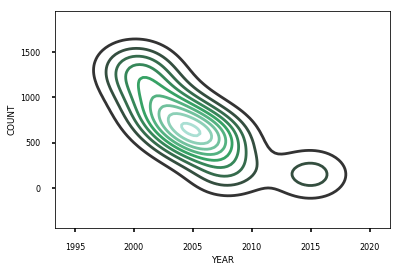

In [89]:
df = pd.DataFrame({
     'YEAR' : year,
     'COUNT' : count,
 })
import seaborn as sns
sns.kdeplot(df.YEAR, df.COUNT)
#This seemingly shows that the number of fires is on the decline, however
#if we look to the total number of acres burned, we see that fire frequency
#does not tell the whole story

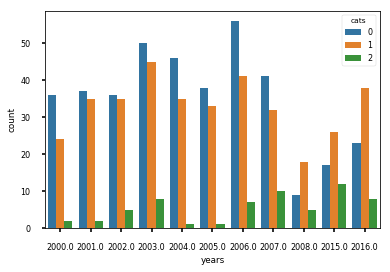

In [91]:
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})
years = clean_df.START_DATE.apply(lambda x: x.year)
def burn_cat(val):
    if val < 1000:
        return 0
    elif val < 25000:
        return 1
    else:
        return 2
cats = clean_df.BURNED_TOTAL.apply(burn_cat)
new_df = pd.DataFrame({'years': years,
                       'cats': cats})
new_df['count'] = 0
new_df = new_df.groupby(['years', 'cats']).count().reset_index()
new_df = new_df[new_df['years'] < 2017.0]
sns.barplot(x='years',y='count', hue='cats', data=new_df)

In [37]:
heat = joined.copy()
heat = heat[['LATITUDE', 'LONGITUDE']]
from folium import plugins
m = folium.Map(location = [36, -119])
stationArr = heat[['LATITUDE', 'LONGITUDE']].as_matrix()
# plot heatmap
m.add_children(plugins.HeatMap(stationArr, radius=15))
m.save("heat.html")

C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  import sys


In [38]:
from IPython.display import IFrame
IFrame("./heat.html", width=1000, height=500)

## EDA
**ALL ANAYLSIS HEREAFTER USES clean_df or joined**

In [39]:
#folium map, this map can be found at the beginning of our report, and can 
#also be viewed by opening the html file called 'map.html'
from IPython.display import HTML, display
m = folium.Map(location = [36, -119])
folium.Choropleth(
    geo_data=ca_counties,
    name='fire_counts',
    data=count_joined,
    columns=['COUNTY', 'COUNT'],
    key_on='feature.properties.COUNTY_NAME',
    fill_color='Reds'
    ).add_to(m)
m.save('map.html')

## TIMESERIES DATA

There are two routes we can take with this data

1. Continual time, so compare fires year to year (e.g. 2014 vs 2015 vs 2016)
2. Seasonal time, so compare fires month to month (e.g. all years in month Jan vs all years in month June)

In [40]:
clean_df

,INCIDENT #,COUNTY/UNIT,FIRE_NAME,START_DATE,CONT_DATE,ORIGIN_DPT,BURNED_TOTAL,VEG_TYPE,CAUSE,STRUCT_DEST,STRUCT_DAM,FATALITY_FIRE,FATALITY_CIVIL
0,TUU-5954,Tulare County,Richgrove,2000-06-28,2000-06-28,CDF,450,G,Elec. Power,0,0,0,0
1,MVU-4431,San Diego County,Barrett,2000-06-29,2000-06-30,CDF,2000,NaN,Under Invest.,NaN,NaN,NaN,NaN
2,MMU-9447,Mariposa County,Granite,2000-07-02,2000-07-04,CDF,2000,WB,Shooter,0,0,0,0
3,BDU-5166,San Bernardino County,Citrus,2000-07-03,2000-07-04,CDF,600,G,Under Invest.,0,0,0,0
4,BDU-5318,San Bernardino County,Assist (Morgan),2000-07-07,2000-07-08,USFS,300,NaN,Under Invest.,na,na,na,na
5,TUU-6521,Tulare County,Success,2000-07-09,2000-07-09,CDF,320,W,Arson,0,0,0,0
6,LMU-1817,Lassen County,Goat,2000-07-17,2000-07-20,CDF,1084,T,Campfire,0,0,0,0
7,SKU-2492,Siskiyou County,Bark KNF Assist #12,2000-07-21,2000-07-26,USFS,1715,na,Under Invest.,na,na,na,na
8,BBD-1891,San Luis Obispo County,Shell,2000-07-22,NaT,USFS,6300,NaN,Under Invest.,NaN,NaN,NaN,NaN
9,MVU-5080,San Diego County,Assist #18 Buckman,2000-07-22,2000-07-22,USFS,300,na,Under Invest.,na,na,na,na


# Proposed Roadmap

1. import economic data
2. start analysis
    1. regression
    1. categorization
    1. deadliest fires
    1. economic dmg
    1. Acres burned of fire related to length of fire
    1. Total acres burned based on start date in DAY/MONTH/YEAR
    1. Multivariate regression for total acres burned based on length of fire and when it starts



# Interesting Finds

Here are some interesting finds from our datasets:

C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


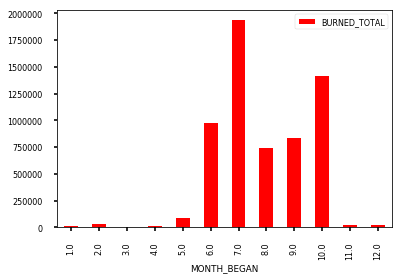

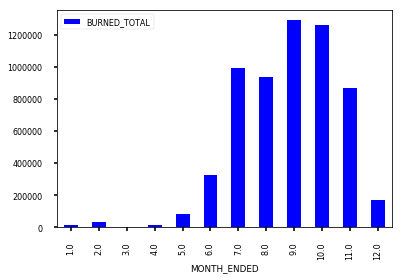

In [100]:
## This section plots the total acres burned based on MONTH the fire BEGAN(red) and ENDED(blue)

an_df = clean_df
dates = an_df['START_DATE'].apply(lambda x: float(x.month))
an_df = an_df.dropna(subset=["START_DATE"])
an_df['START_DATE'] = dates

an_df = an_df[['START_DATE', 'BURNED_TOTAL']]
aggregation_functions = {'BURNED_TOTAL': 'sum'}
df_new = an_df.groupby(an_df['START_DATE']).aggregate(aggregation_functions).reset_index()
df_new.columns = ['MONTH_BEGAN', 'BURNED_TOTAL']
#display(df_new)
df_new.plot('MONTH_BEGAN', 'BURNED_TOTAL', kind='bar', color='red')



anb_df = clean_df
dates = anb_df['CONT_DATE'].apply(lambda x: float(x.month))
anb_df = anb_df.dropna(subset=["CONT_DATE"])
anb_df['CONT_DATE'] = dates

anb_df = anb_df[['CONT_DATE', 'BURNED_TOTAL']]
aggregation_functions = {'BURNED_TOTAL': 'sum'}
df_newb = anb_df.groupby(anb_df['CONT_DATE']).aggregate(aggregation_functions).reset_index()
df_newb.columns = ['MONTH_ENDED', 'BURNED_TOTAL']
df_newb.plot('MONTH_ENDED', 'BURNED_TOTAL', kind='bar', color='blue')

C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


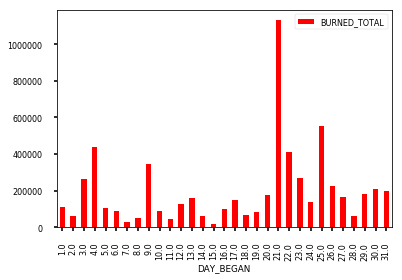

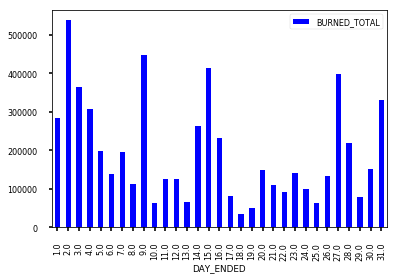

In [99]:
##This section plots the total acres burned based on DAY the fire BEGAN and ENDED
day_df = clean_df
dates = day_df['START_DATE'].apply(lambda x: float(x.day))
day_df = day_df.dropna(subset=['START_DATE'])
day_df['START_DATE'] = dates

day_df = day_df[['START_DATE', 'BURNED_TOTAL']]
aggregation_functions = {'BURNED_TOTAL': 'sum'}
df_new = day_df.groupby(day_df['START_DATE']).aggregate(aggregation_functions).reset_index()
df_new.columns = ['DAY_BEGAN', 'BURNED_TOTAL']
#display(df_new)
df_new.plot('DAY_BEGAN', 'BURNED_TOTAL', kind='bar', color='red')



dayb_df = clean_df
dates = dayb_df['CONT_DATE'].apply(lambda x: float(x.day))
dayb_df = dayb_df.dropna(subset=['CONT_DATE'])
dayb_df['CONT_DATE'] = dates

dayb_df = dayb_df[['CONT_DATE', 'BURNED_TOTAL']]
aggregation_functions = {'BURNED_TOTAL': 'sum'}
dfb_new = dayb_df.groupby(dayb_df['CONT_DATE']).aggregate(aggregation_functions).reset_index()
dfb_new.columns = ['DAY_ENDED', 'BURNED_TOTAL']
#display(df_new)
dfb_new.plot('DAY_ENDED', 'BURNED_TOTAL', kind='bar', color='blue')

C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


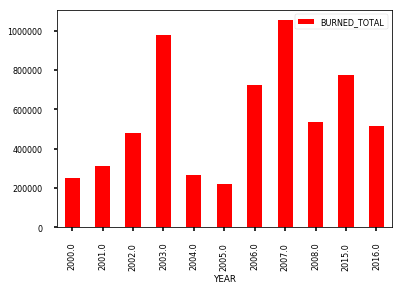

In [97]:
##This section plots the total acres burned based on YEAR the fire BEGAN
year_df = clean_df
dates = year_df['START_DATE'].apply(lambda x: float(x.year))
year_df = year_df.dropna(subset=['START_DATE'])
year_df['START_DATE'] = dates
#display(year_df)

year_df = year_df[['START_DATE', 'BURNED_TOTAL']]
aggregation_functions = {'BURNED_TOTAL': 'sum'}
df_new = year_df.groupby(year_df['START_DATE']).aggregate(aggregation_functions).reset_index()
df_new.columns = ['YEAR', 'BURNED_TOTAL']
df_new = df_new[df_new['YEAR'] < 2017]
#display(df_new)
df_new.plot('YEAR', 'BURNED_TOTAL', kind='bar', color='red')
#df_new['YEAR'].unique()

C:\Users\kyleg\ANACONDA\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


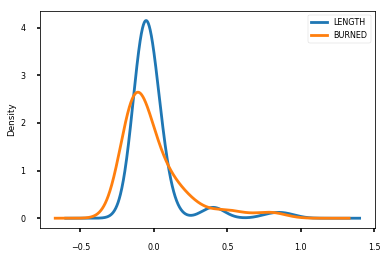

In [96]:
cdf = clean_df

length = cdf['CONT_DATE'] - cdf['START_DATE']
#display(length)
cdf = cdf[['START_DATE', 'BURNED_TOTAL']]
cdf['START_DATE']= length
cdf.columns=['LENGTH', 'BURNED']


len_df = cdf[['LENGTH', 'BURNED']]
aggregation_functions = {'BURNED': 'sum'}
len_df = len_df.groupby('LENGTH').mean().reset_index()
len_df['LENGTH'] = len_df['LENGTH'].apply(lambda x: x.days)
#len_df['BURNED'] = len_df['BURNED'].apply(lambda x: x/)
len_df = len_df.drop([0,1,2])
#normalizing the data to better view the kde plot
len_df = (len_df - len_df.mean()) / (len_df.max() - len_df.min())
len_df.plot(kind='kde')
#plt.scatter(len_df['LENGTH'], len_df['BURNED'], c = 'green')
#len_df.plot('LENGTH', 'BURNED', kind='bar', color='red')
#len_df['LENGTH'].unique()

# Results and Conclusion

1) We previously defined **"efficiently allocated"** as ... and we can use _____ and ______ to predict _____